## Imports, Reading Data, Setting up tests

In [5]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


In [2]:
training_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/broadband_training_bin_1.csv')
test_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/broadband_test_bin_1.csv')


In [3]:
all_vars = list(training_data.columns.values[(training_data.dtypes=='float64') | (training_data.dtypes=='int')])
remove_vars = ['pct_health_ins_children','pct_health_ins_19_64','pct_health_ins_65+']

for i in remove_vars:
    all_vars.remove(i)

## Modeling

### Functions

In [4]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [8]:
Y_train = np.array(training_data['pct_health_ins_19_64'])
Y_test = np.array(test_data['pct_health_ins_19_64'])

def RF_model(train_df, 
             test_df, 
             variable_list,
             Y_train = Y_train,  
             Y_test = Y_test):
    train_variables = np.array(train_df[variable_list])
    test_variables = np.array(test_df[variable_list])
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 42).fit(train_variables, Y_train)
    predicted = model.predict(test_variables)
    
    regression_results(Y_test, predicted)
    
    return pd.DataFrame(model.feature_importances_, 
                        index = variable_list).sort_values(by=0, ascending = False)


In [9]:
feature_importance_all_vars = RF_model(training_data, 
                                       test_data, 
                                       all_vars)


explained_variance:  0.7433
r2:  0.7432
MAE:  3.6623
MSE:  24.314
RMSE:  4.9309


From the all_vars model, we can pick the top variables to use in the grid search. There's a pretty steep dropoff after the 8th variable, so let's just use those.

<AxesSubplot:>

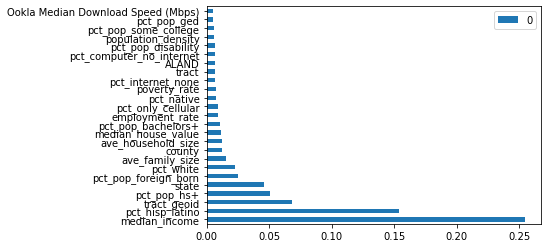

In [10]:
feature_importance_all_vars.head(25).plot.barh()

In [13]:
feature_importance_all_vars.head(7).index.values

array(['median_income', 'pct_hisp_latino', 'tract_geoid', 'pct_pop_hs+',
       'state', 'pct_pop_foreign_born', 'pct_white'], dtype=object)

In [49]:
key_vars = ['median_income', 
            'pct_hisp_latino', 
            'tract_geoid', 
            'pct_pop_hs+',
            'state', 
            'pct_pop_foreign_born', 
            'pct_white']

None of the most relevant metrics actually relate to broadband metrics..

---

## Use Grid Search to find best hyperparameters

In [51]:
# Number of trees in random forest
n_estimators = [100, 200, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 500, 1000]}


In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and us

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(training_data[key_vars], poverty_rate_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  52.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  53.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  56.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 2.7min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 3.8min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 3.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [57]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [60]:
predictions = rf_random.predict(test_data[key_vars])

In [62]:
regression_results(poverty_rate_test, predictions)

explained_variance:  0.7276
r2:  0.7276
MAE:  4.1451
MSE:  32.6335
RMSE:  5.7126


Optimizing has created a much better model! 